In [35]:
import numpy as np
from sources.preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sources.api_connect import project_path
import os
import pandas as pd

In [71]:
def pipeline_preprocesing(df:pd.DataFrame() = pd.read_csv(os.path.join(project_path, 'database.nosync', 'updated_table.csv'))):
    # Instantion d'une table ranking
    data = prep_ranking()
    # Modification des ID joueurs par le classement ATP associé
    df[['player1_id', 'player2_id', 'winner_id']] = df[['player1_id', 'player2_id', 'winner_id']].replace(dict(zip(data['id'], data['rank'])))
    # Remplacement des ID joueurs hors classement ATP par un 1000 pour marquer la différence
    df['player1_id'] = df['player1_id'].replace(to_replace='^.*$', value=1000, regex=True)
    df['player2_id'] = df['player2_id'].replace(to_replace='^.*$', value=1000, regex=True)
    # Création de la variable cible, 0 si le joueur 1 gagne et 1 si le joueur 2 gagne
    df['winner_is'] = np.where(df['player1_id'] == df['winner_id'], 0, 1)

    def inverse_dual(df_1:pd.DataFrame):
        df2 = df_1.copy()
        df2['player1_id'], df2['player2_id'] = df_1['player2_id'], df_1['player1_id']
        df2['home_score'], df2['away_score'] = df_1['away_score'], df_1['home_score']
        df2['winner_is'] = df['winner_is'].replace({0: 1, 1: 0})
        return pd.concat([df_1, df2], axis=0)

    # Duplication du DF en changeant le joueur 1
    df = inverse_dual(df_1 = df)
    # Création d'une variable dépendante représentant la difference au classement ATP entre les deux adversaires
    df['atp_difference'] = df['player1_id'] - df['player2_id']
    # Création d'une variable dépendante représentant la difference au score sur un match entre les deux adversaires
    # Variable non utilisée car connue post-match
    df['score_difference'] = df['home_score'] - df['away_score']
    df.drop_duplicates(inplace=True)
    return df

dataframe = pipeline_preprocesing()

https://api.sportradar.com/tennis/trial/v2/fr/players/rankings.json
200


In [85]:
display(dataframe)

,Unnamed: 0,match_id,scheduled,player1_id,player2_id,winner_id,home_score,away_score,winner_is,atp_difference,score_difference
0,0,sr:match:41061433,2023-05-15T11:20:00+00:00,1,115,115,2.0,0.0,1,-114,2.0
1,1,sr:match:41061401,2023-05-13T14:10:00+00:00,1,66,1,0.0,2.0,0,-65,-2.0
2,2,sr:match:40788805,2023-05-07T16:30:00+00:00,26,1,1,2.0,1.0,1,25,1.0
3,3,sr:match:40788801,2023-05-05T14:00:00+00:00,16,1,1,2.0,0.0,1,15,2.0
4,4,sr:match:40788873,2023-05-03T14:00:00+00:00,11,1,1,2.0,0.0,1,10,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1995,5,sr:match:40191757,2023-03-23T16:20:00+00:00,47,200,47,1.0,2.0,0,-153,-1.0
1996,6,sr:match:39880843,2023-03-07T23:25:00+00:00,70,200,70,1.0,2.0,0,-130,-1.0
1997,7,sr:match:39826429,2023-03-07T01:55:00+00:00,200,126,200,0.0,2.0,0,74,-2.0
1998,8,sr:match:39160489,2023-02-05T18:35:00+00:00,200,285,285,2.0,1.0,1,-85,1.0


In [87]:
X, y = dataframe[['player1_id', 'player2_id', 'atp_difference']], dataframe['winner_is']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrainement d'une regression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63       379
           1       0.64      0.65      0.64       382

    accuracy                           0.64       761
   macro avg       0.64      0.64      0.64       761
weighted avg       0.64      0.64      0.64       761



In [88]:
# Entrainement d'un SVC

model2 = SVC(kernel='linear')
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       379
           1       0.64      0.65      0.65       382

    accuracy                           0.64       761
   macro avg       0.64      0.64      0.64       761
weighted avg       0.64      0.64      0.64       761



In [33]:
## Idées de variables a approfondir :
# - Forme physique, date depuis le dernier match, nombre de sets joués au dernier match
# - % de victoire sur les n-derniers matchs..
# - Historique de confrontation entre les deux adversaires
# - Surface du terrain

/var/folders/_z/m9mrvx6j14s1w4n961v7j2800000gn/T/ipykernel_52231/2044838809.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataframe['atp_difference_group'] = dataframe['atp_difference_group'].astype(str).str.split(',').str[0].str.replace('(', '')


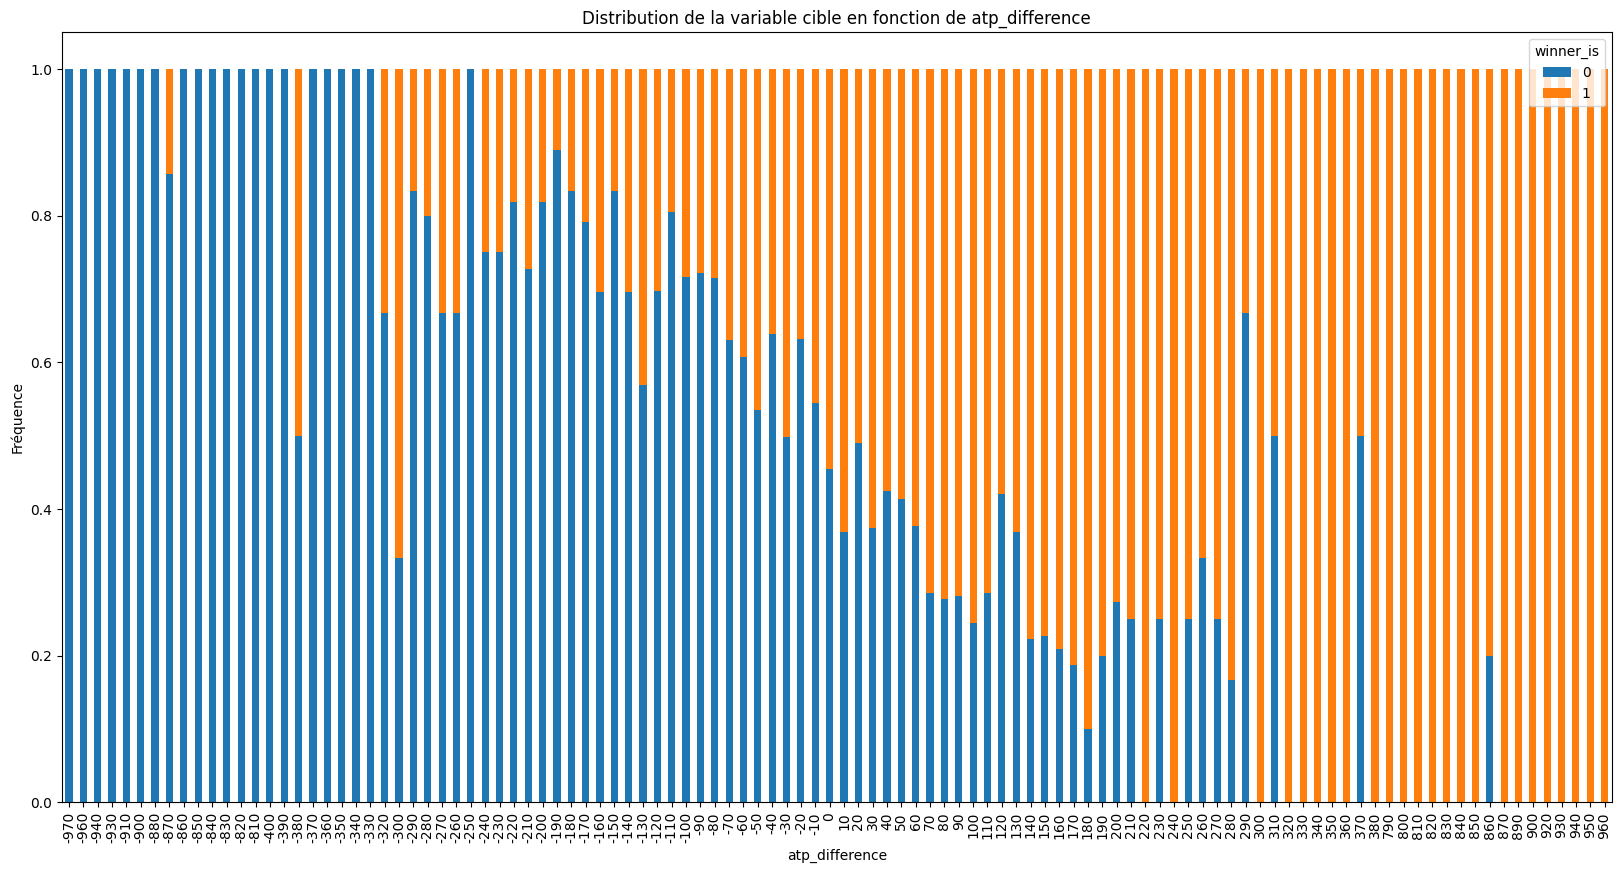

In [128]:
import matplotlib.pyplot as plt

dataframe['atp_difference_group'] = pd.cut(dataframe['atp_difference'], bins=range(-1000, 1001, 10))
dataframe['atp_difference_group'] = dataframe['atp_difference_group'].astype(str).str.split(',').str[0].str.replace('(', '')
dataframe['atp_difference_group'] = dataframe['atp_difference_group'].astype(int)
# Regroupement des données par la variable ATP_différence et calcul de la fréquence des valeurs de la variable cible
grouped_data = dataframe.groupby('atp_difference_group')['winner_is'].value_counts(normalize=True).unstack()

# Création du graphique de barres
grouped_data.plot(kind='bar', stacked=True, figsize=(20, 10))

# Définition des étiquettes des axes et du titre
plt.xlabel('atp_difference')
plt.ylabel('Fréquence')
plt.title('Distribution de la variable cible en fonction de atp_difference')

# Affichage du graphique
plt.show()


In [130]:
display(dataframe)

,Unnamed: 0,match_id,scheduled,player1_id,player2_id,winner_id,home_score,away_score,winner_is,atp_difference,score_difference,atp_difference_group
0,0,sr:match:41061433,2023-05-15T11:20:00+00:00,1,115,115,2.0,0.0,1,-114,2.0,-120
1,1,sr:match:41061401,2023-05-13T14:10:00+00:00,1,66,1,0.0,2.0,0,-65,-2.0,-70
2,2,sr:match:40788805,2023-05-07T16:30:00+00:00,26,1,1,2.0,1.0,1,25,1.0,20
3,3,sr:match:40788801,2023-05-05T14:00:00+00:00,16,1,1,2.0,0.0,1,15,2.0,10
4,4,sr:match:40788873,2023-05-03T14:00:00+00:00,11,1,1,2.0,0.0,1,10,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,sr:match:40191757,2023-03-23T16:20:00+00:00,47,200,47,1.0,2.0,0,-153,-1.0,-160
1996,6,sr:match:39880843,2023-03-07T23:25:00+00:00,70,200,70,1.0,2.0,0,-130,-1.0,-140
1997,7,sr:match:39826429,2023-03-07T01:55:00+00:00,200,126,200,0.0,2.0,0,74,-2.0,70
1998,8,sr:match:39160489,2023-02-05T18:35:00+00:00,200,285,285,2.0,1.0,1,-85,1.0,-90


In [149]:
dataframe['atp_difference_grouped'] = pd.cut(dataframe['atp_difference'], bins=range(-1000, 1001, 100))
dataframe['atp_difference_grouped'] = dataframe['atp_difference_grouped'].astype(str).str.split(',').str[0].str.replace('(', '')
dataframe['atp_difference_grouped'] = dataframe['atp_difference_grouped'].astype(int)

/var/folders/_z/m9mrvx6j14s1w4n961v7j2800000gn/T/ipykernel_52231/3734545413.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataframe['atp_difference_grouped'] = dataframe['atp_difference_grouped'].astype(str).str.split(',').str[0].str.replace('(', '')


In [151]:
dataframe[dataframe.winner_is == True].groupby(['atp_difference_grouped']).count()['winner_is']

atp_difference_grouped
-900      1
-400      2
-300     15
-200     79
-100    576
 0      890
 100    207
 200     52
 300     26
 700      1
 800     39
 900     13
Name: winner_is, dtype: int64

In [156]:
played =dataframe.groupby(['atp_difference_grouped']).count()['match_id']
victory = dataframe[dataframe.winner_is == True].groupby(['atp_difference_grouped']).count()['winner_is']

<AxesSubplot:xlabel='atp_difference_grouped'>

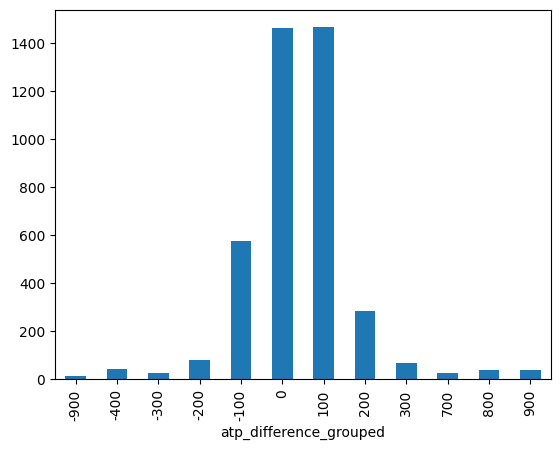

In [163]:
played.plot(kind='bar')
victory.plot(kind='bar')

In [ ]:
def normalized_counter(subset, data_frame, by):
    return(subset / data_frame[by].value_counts()[subset.columns].values * max(data_frame[by].value_counts()[subset.columns].values)).round(0).astype(int)

In [ ]:
def split_data_per_flag(data_frame, grouped_by='shot_distance_range'):
    temporary = data_frame[(data_frame[position].isin(starter_position)) & data_frame['shot_distance_range'].isin(np.arange(0, 41, 5))]
    subset_temporary_attempted = temporary.groupby([grouped_by, position])
    subset_data_made = temporary[temporary[shot_made_flag] == 1].groupby([grouped_by, position])
    attempted = normalized_counter(subset_temporary_attempted.count()['game_id'].unstack(-1), temporary, by=position)
    scored = normalized_counter(subset_data_made.count()['game_id'].unstack(-1), temporary, by=position)
    return attempted, scored

attempted, scored = split_data_per_flag(locations)

In [ ]:
def figure_3(attempted_:pd.DataFrame, scored_=pd.DataFrame, save_fig=False):
    fig, ax = plt.subplots(1)
    plt.style.use({'figure.facecolor': 'white'})
    attempted_.plot(kind='bar', figsize=(30,15), color = 'tab:blue', edgecolor='black', ax=ax, label=None, zorder=10)

    ax = plt.gca()
    pos = []
    for bar in ax.patches:
        pos.append(bar.get_x()+bar.get_width()/2.)

    lab = []
    for i in range(len(pos)):
        l = attempted_.columns.values[i//len(attempted_.index.values)]
        lab.append(f'\n{l}')

    scored_.plot(kind='bar', figsize=(30,15), color = 'tab:orange', edgecolor='black', ax=ax, label=None, zorder=10)

    counter = 0
    for col in range(attempted_.shape[1]):
        for row in range(attempted_.shape[0]):
            ax.text(pos[counter],
                    attempted_.iloc[row, col] + 10000,
                    f'{((scored_.iloc[row, col] / attempted_.iloc[row, col]) *100).round(1)}%',
                    ha="center", fontsize=12, rotation=90)
            counter += 1

    ax.set_xlabel('shoot type', fontdict={"style": "italic"})
    ax.set_ylabel('normalized counts', fontdict={"style": "italic"})
    ax.set_xticks(pos,minor=True)
    ax.set_xticklabels(['PG\n\n {}'.format(i) for i in list(attempted_.index)], minor=False, rotation=0, fontsize=12)
    ax.set_xticklabels(lab,minor=True, fontsize=12)
    ax.tick_params(axis='x', which='major', pad=9, size=10)
    plt.setp(ax.get_xticklabels(), rotation=0)
    ax.set_title('Réussite du tir par poste en fonction du type de tirs', fontsize=15, pad=15, fontweight='bold')
    ax.legend().remove()

    attempted = mpatches.Patch(color='tab:blue', label='Attempted')
    scored = mpatches.Patch(color='tab:orange', label='Scored')
    poste_legend = mpatches.Patch(color='white', label='\nPG : Meneur\nSG : Arrière\nSF : Ailier\nPF : Ailier fort\nC : Pivot')
    ax.legend(handles=[attempted, scored, poste_legend])

    if save_fig:
        filename = ax.get_title().lower().replace(' ', '_') + '.png'
        plt.savefig(os.path.join(project_path, 'eda', 'figure_output', filename), dpi=300, bbox_inches='tight')
    plt.show()

figure_3(attempted2, scored2)